<a href="https://colab.research.google.com/github/AnkitSingh-MLE/EcomRecommendationSystem/blob/main/Recom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24999 entries, 0 to 24998
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    24999 non-null  object 
 1   customer_id             24999 non-null  int64  
 2   product_category        24999 non-null  int64  
 3   payment_method          24999 non-null  object 
 4   value [USD]             24999 non-null  float64
 5   time_on_site [Minutes]  24999 non-null  float64
 6   clicks_in_site          24999 non-null  int64  
 7   Unnamed: 7              0 non-null      float64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.5+ MB


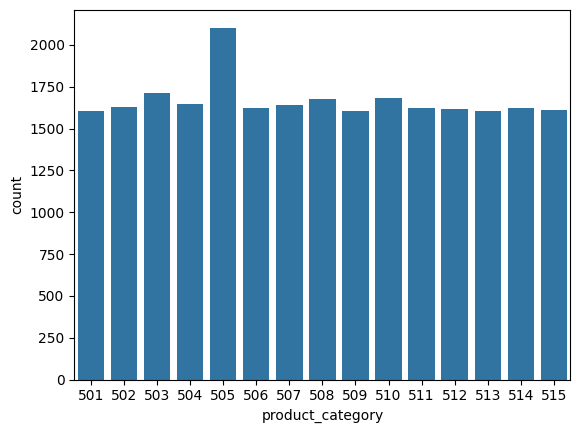

In [ ]:
# Import essential libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting data visualizations
import seaborn as sns  # For statistical data visualizations
from sklearn.model_selection import train_test_split  # For splitting the data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For normalizing the data
from sklearn.metrics import mean_squared_error  # For evaluating model performance
from sklearn.neighbors import NearestNeighbors  # For building a recommendation model using Nearest Neighbors


# Loading the datasets (make sure the file paths are correct)
purchase_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/E-comm Purchase/purchase_data_exe.csv')
# Check first few rows of the dataset
purchase_data.head()

# Check for missing values and data types
purchase_data.info()

# Descriptive statistics
purchase_data.describe()

# Visualize the distribution of key features
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='product_category', data=purchase_data) # Visualize product categories, for example
plt.show()

#Dropping Irrelevant Columns
purchase_data.drop(columns=['Unnamed: 7'], inplace=True)

In [ ]:
#Feature Engineering and EDA

# Check for missing values
purchase_data.isnull().sum()


#Extract Date-Time Features
import pandas as pd

# Convert 'date' to datetime format
purchase_data['date'] = pd.to_datetime(purchase_data['date'], dayfirst=True)

# Extract day of the week (0 = Monday, 6 = Sunday)
purchase_data['weekday'] = purchase_data['date'].dt.weekday

# Extract hour of the day
purchase_data['hour'] = purchase_data['date'].dt.hour

# Extract month
purchase_data['month'] = purchase_data['date'].dt.month

# Check the first few rows
print(purchase_data[['date', 'weekday', 'hour', 'month']].head())


# Compute total amount spent per customer
customer_spending = purchase_data.groupby('customer_id')['value [USD]'].sum().reset_index()
customer_spending.rename(columns={'value [USD]': 'total_spent'}, inplace=True)

# Merge with original dataset
purchase_data = purchase_data.merge(customer_spending, on='customer_id', how='left')

# Compute average spending per transaction
purchase_data['avg_transaction_value'] = purchase_data['total_spent'] / purchase_data.groupby('customer_id')['customer_id'].transform('count')

# Check the first few rows
print(purchase_data[['customer_id', 'total_spent', 'avg_transaction_value']].head())



        date  weekday  hour  month
0 2018-11-20        1     0     11
1 2018-11-20        1     0     11
2 2018-11-20        1     0     11
3 2018-11-20        1     0     11
4 2018-11-20        1     0     11
   customer_id  total_spent  avg_transaction_value
0        37077        49.53                  49.53
1        59173        50.61                  50.61
2        41066        85.99                  85.99
3        50741        34.60                  34.60
4        53639       266.27                 266.27


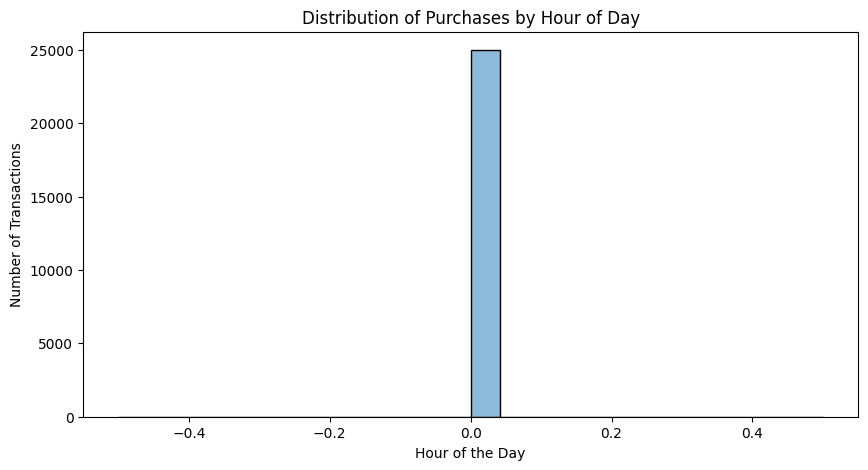

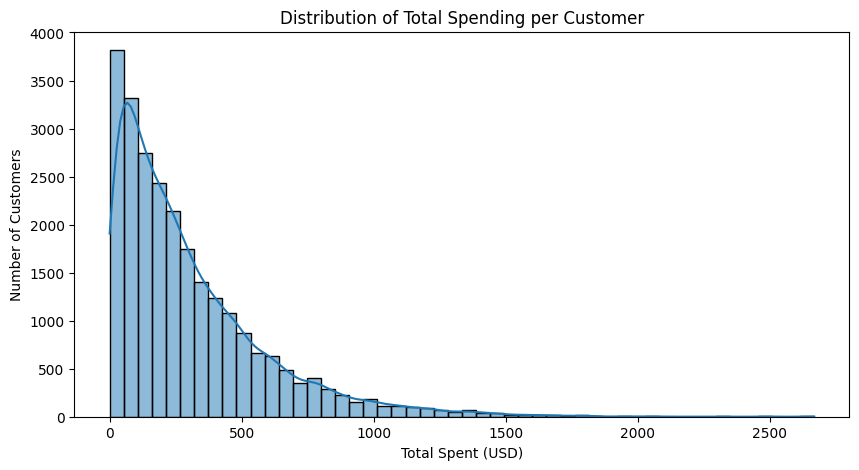

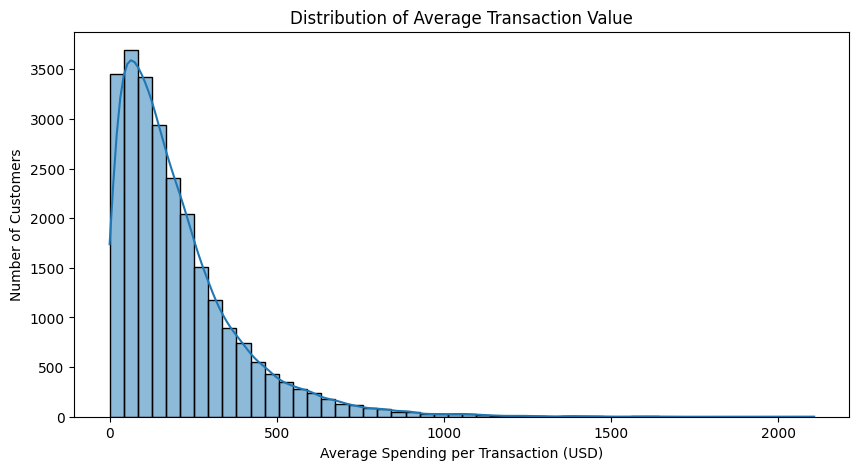

In [ ]:
#Visualizing Feature Distributions
#Distribution of Purchases by Hour of the Day
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(purchase_data['hour'], bins=24, kde=True)
plt.title("Distribution of Purchases by Hour of Day")
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.show()

#Total Spending Distribution
plt.figure(figsize=(10, 5))
sns.histplot(purchase_data['total_spent'], bins=50, kde=True)
plt.title("Distribution of Total Spending per Customer")
plt.xlabel("Total Spent (USD)")
plt.ylabel("Number of Customers")
plt.show()

# Average Transaction Value Distribution
plt.figure(figsize=(10, 5))
sns.histplot(purchase_data['avg_transaction_value'], bins=50, kde=True)
plt.title("Distribution of Average Transaction Value")
plt.xlabel("Average Spending per Transaction (USD)")
plt.ylabel("Number of Customers")
plt.show()


In [ ]:
#Normalise the features
# Drop the 'hour' column
purchase_data.drop(columns=['hour'], inplace=True, errors='ignore')

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Scaling numerical columns
purchase_data[['value [USD]', 'time_on_site [Minutes]', 'clicks_in_site', 'total_spent', 'avg_transaction_value']] = scaler.fit_transform(
    purchase_data[['value [USD]', 'time_on_site [Minutes]', 'clicks_in_site', 'total_spent', 'avg_transaction_value']]
)

# Check the transformed values
print(purchase_data.head())


        date  customer_id  product_category payment_method  value [USD]  \
0 2018-11-20        37077               505         credit    -0.738991   
1 2018-11-20        59173               509         paypal    -0.733799   
2 2018-11-20        41066               507         credit    -0.563713   
3 2018-11-20        50741               506         credit    -0.810766   
4 2018-11-20        53639               515         paypal     0.302970   

   time_on_site [Minutes]  clicks_in_site  weekday  month  total_spent  \
0               -0.404903       -0.600148        1     11    -0.870313   
1               -0.312839       -0.600148        1     11    -0.866590   
2               -0.253228       -0.376202        1     11    -0.744613   
3               -0.375098       -0.525499        1     11    -0.921786   
4               -0.198917        1.042121        1     11    -0.123075   

   avg_transaction_value  
0              -0.833361  
1              -0.827506  
2              -0.63569

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode payment_method
purchase_data['payment_method'] = label_encoder.fit_transform(purchase_data['payment_method'])

# Check encoding results
print(purchase_data[['payment_method']].head())


   payment_method
0               0
1               1
2               0
3               0
4               1


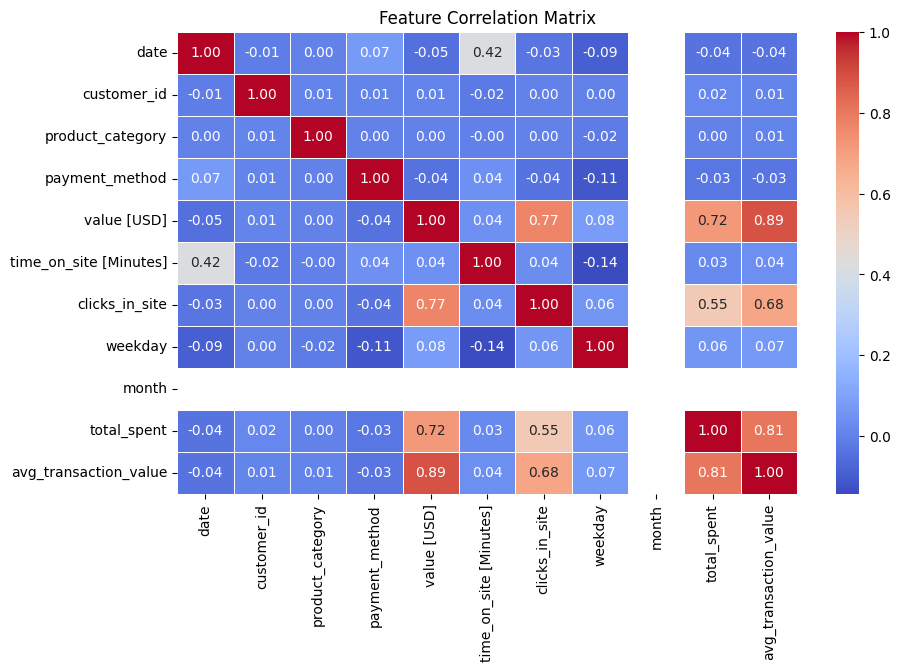

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
correlation_matrix = purchase_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


<ipython-input-39-f69ba149f720>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")


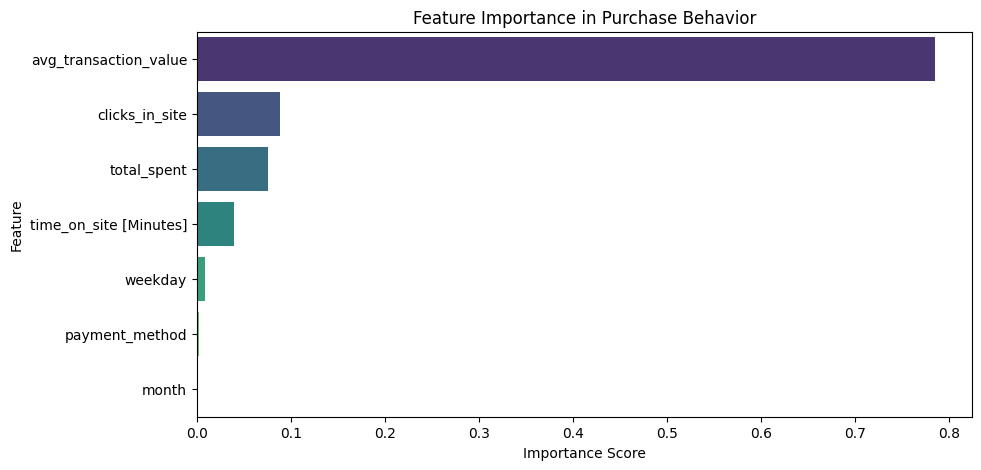

In [ ]:
#Feature Importance using Random Forest

from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Selecting relevant features for importance analysis
features = ['payment_method', 'clicks_in_site', 'time_on_site [Minutes]', 'total_spent', 'avg_transaction_value', 'weekday', 'month']
X = purchase_data[features]
y = purchase_data['value [USD]']  # Target: Purchase Value

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Get feature importances
feature_importances = rf.feature_importances_

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
plt.title("Feature Importance in Purchase Behavior")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


In [ ]:
from sklearn.neighbors import NearestNeighbors

# Step 1: Prepare feature matrix with the selected top features
features = ['avg_transaction_value', 'clicks_in_site', 'total_spent', 'time_on_site [Minutes]', 'weekday', 'payment_method']
X = purchase_data[features]

# Step 2: Initialize KNN model
knn = NearestNeighbors(n_neighbors=5, metric='cosine')  # Using cosine similarity

# Step 3: Fit the model on the user feature matrix
knn.fit(X)

# Step 4: Find the top 5 similar users for a specific user (e.g., user 0)
distances, indices = knn.kneighbors([X.iloc[0]], n_neighbors=5)

# Output: Display the indices of the most similar users for User 0
print(f"Top 5 similar users for User 0: {indices[0]}")


Top 5 similar users for User 0: [    0 19937  1251 18834  1957]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
# Step 1: Create a user-item interaction matrix (user vs. payment_method)
user_item_matrix = purchase_data.pivot_table(index='customer_id', columns='payment_method', values='avg_transaction_value', aggfunc='sum')

# Step 2: Fill missing values with zeros (as we assume no interaction means zero value)
user_item_matrix_filled = user_item_matrix.fillna(0)

# Step 3: Initialize KNN model
knn = NearestNeighbors(n_neighbors=5, metric='cosine')

# Step 4: Fit the KNN model on the interaction matrix
knn.fit(user_item_matrix_filled)

# Step 5: Find top 5 similar users for user 0
distances, indices = knn.kneighbors([user_item_matrix_filled.iloc[0]], n_neighbors=5)

# Output: Display top 5 similar users
print(f"Top 5 similar users for User 0: {indices[0]}")


Top 5 similar users for User 0: [ 8487  2257 12372  8494 15097]
